Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 42ms/step - accuracy: 0.3462 - loss: 1.7645 - val_accuracy: 0.5593 - val_loss: 1.2456
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.5728 - loss: 1.2063 - val_accuracy: 0.6129 - val_loss: 1.0951
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.6413 - loss: 1.0194 - val_accuracy: 0.6444 - val_loss: 1.0378
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.6771 - loss: 0.9225 - val_accuracy: 0.6713 - val_loss: 0.9290
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.7082 - loss: 0.8484 - val_accuracy: 0.6902 - val_loss: 0.8930
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.7267 - loss: 0.7801 - val_accuracy: 0.7030 - val_loss: 0.8636
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.7432 - loss: 0.7349 - val_accuracy: 0.6872 - val_loss: 0.9148
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7515 -

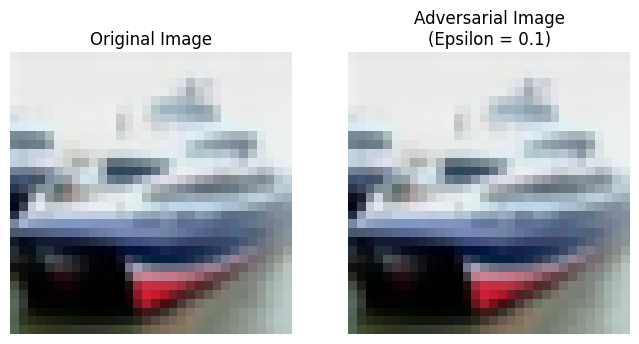

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Original label: 8
Predicted label for adversarial image: 8


In [2]:
# Step 1: Install necessary libraries (if not already installed)
!pip install tensorflow matplotlib

# Step 2: Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Load CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize images to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Step 4: Build a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Step 5: Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Step 6: Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Step 7: Evaluate the model on clean test images
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'\nTest accuracy on clean images: {test_acc}')

# Step 8: Create adversarial attack using FGSM (Fast Gradient Sign Method)
def create_adversarial_pattern(model, image, label):
    with tf.GradientTape() as tape:
        # Watch the image to compute the gradient
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

    # Get the gradients of the loss w.r.t the input image
    gradient = tape.gradient(loss, image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

# Step 9: Test the model with adversarial examples
def generate_adversarial_example(image, label, epsilon):
    image = tf.convert_to_tensor(image.reshape((1, 32, 32, 3)))
    label = tf.convert_to_tensor(label.reshape((1,)))

    perturbation = create_adversarial_pattern(model, image, label)
    adversarial_image = image + epsilon * perturbation
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # Keep pixel values in [0, 1]

    return adversarial_image.numpy()

# Select one test image and label to create adversarial example
image = test_images[1]
label = test_labels[1]

# Set epsilon value (attack strength)
epsilon = 0.1

# Generate adversarial image
adversarial_image = generate_adversarial_example(image, label, epsilon)

# Step 10: Visualize the original and adversarial images
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Adversarial image
plt.subplot(1, 2, 2)
plt.title(f'Adversarial Image\n(Epsilon = {epsilon})')
plt.imshow(adversarial_image[0])
plt.axis('off')

plt.show()

# Step 11: Test the CNN model on the adversarial image
image_input = np.expand_dims(adversarial_image[0], axis=0)
prediction = model.predict(image_input)
predicted_label = np.argmax(prediction)

print(f'Original label: {label[0]}')
print(f'Predicted label for adversarial image: {predicted_label}')
